<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group: Assignment 1 28

Authors: Medha Hegde (1592718), Gergely Szakállas (1608428)

In [1]:
import requests
import io
import pandas as pd
import xarray as xa

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load training/testing dataset

In [2]:
def load_dataset_from_url(url):
    """
    Loads a dataset from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    response = requests.get(url)
    response.raise_for_status()
    
    dataset = np.load(io.BytesIO(response.content)) 
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y
    
    
# Downloading may take a while..
train_x, train_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/gVrTFgSJ1rWl1IN/download')
test_x, test_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/JR0WXbrzzTAmwEB/download')


print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (10000, 1000, 9)
train_y shape: (10000, 1000, 1)

test_x shape: (2000, 1000, 9)
test_y shape: (2000, 1000, 1)


### Visualize some of the training samples

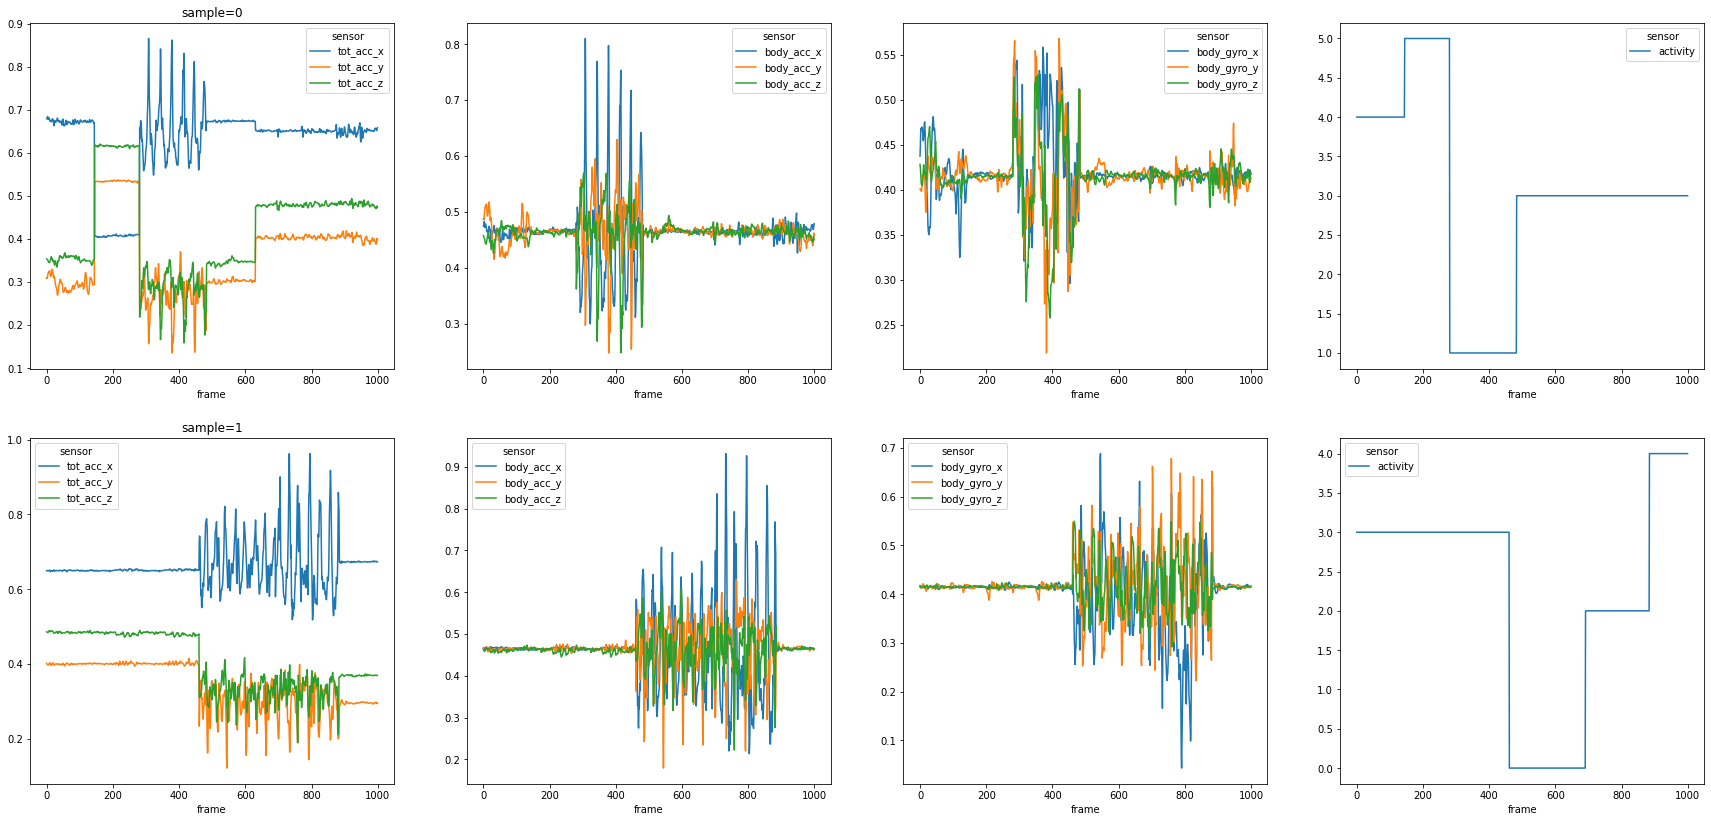

In [3]:
def to_df(x, y):
    """
    Converts training/testing input features and corresponding labels into
    a Pandas Dataframe format
    
    Inputs:
    x: Input features (train or test) in numpy array format
    y: Targets/labels (train or test) in numpy array format
    
    Output:
    dataset_df: Train or test data, structered as a table with column names
    """
    
    numpy_data = np.concatenate([x,y], axis=2)
    
    dataset_df = xa.DataArray(numpy_data, 
                                     dims = ['N', 'frame', 'sensor'],
                                     name='training_data')\
                                        .to_dataframe()\
                                        .unstack('sensor')['training_data']\
                                        .reset_index()

    column_names = ['tot_acc_x', 'tot_acc_y', 'tot_acc_z', 'body_acc_x', 'body_acc_y',
       'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'activity']
    
    dataset_df = dataset_df.rename(columns = dict(zip(list(dataset_df.columns[2:]), 
                                                      column_names)))\
                                         .astype({'activity':int})

    return dataset_df



def plot_training_samples(N, dataset_df):
    """
    Plots samples in test/train dataset
    
    Inputs 
    N: Number of samples that will be visualised. 
    dataset_df: Train or test data, structered as a table with column names. 
                This tabular structured data can be obtained with `to_df` function.
    """
    
    f, axes = plt.subplots(N, 4, figsize=(30, N*7))
    axes = iter(axes)

    for pid, df_pid in list(dataset_df.groupby('N'))[:N]:

        ax_tot_acc, ax_body_acc, ax_body_gyro, ax_activity = tuple(next(axes))

        df_pid.plot(x = 'frame', y=['tot_acc_x','tot_acc_y', 'tot_acc_z'], title=f'sample={pid}', ax=ax_tot_acc)
        df_pid.plot(x = 'frame', y=['body_acc_x','body_acc_y', 'body_acc_z'], ax=ax_body_acc)
        df_pid.plot(x = 'frame', y=['body_gyro_x','body_gyro_y', 'body_gyro_z'], ax=ax_body_gyro)
        df_pid.plot(x = 'frame', y=['activity'], ax=ax_activity) 
        
    
    

training_data_df = to_df(train_x, train_y)

plot_training_samples(2, training_data_df);

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate training and test datasets
train_ds = TensorDataset(torch.from_numpy(np.array(train_x, dtype=np.float32)).to(device), torch.from_numpy(np.array(train_y.reshape(10000,1000), dtype=int)).to(device))
test_ds = TensorDataset(torch.from_numpy(np.array(test_x, dtype=np.float32)).to(device), torch.from_numpy(np.array(test_y.reshape(2000,1000), dtype=int)).to(device))
# Generate dataloaders for train and validation sets split in 80-20% ratio
size = len(train_y)
train_size = int(0.8*size)
train_ds, valid_ds = random_split(train_ds, (train_size, size-train_size))
train_dl, valid_dl = DataLoader(train_ds, batch_size=batch_size), DataLoader(valid_ds, batch_size=batch_size*2)
# Generate dataloader for test set
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [5]:
from torch import nn
import torch.nn.functional as F

class CNNRNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(9, 64, 3, padding=1)
        self.rnn = nn.LSTM(64, 128, 1, batch_first=True)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = x.permute((0,2,1))
        x = F.relu(self.conv(x))
        x = x.permute((0,2,1))
        out, state = self.rnn(x)
        x = F.relu(self.fc1(out))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [6]:
from torch import optim, nn

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    tl, ta, vl, va = [], [], [], []
    for epoch in range(epochs):
        # Train
        model.train()
        train_steps = 0
        total_train = len(train_dl)
        train_loss = []
        train_accuracy = []
        for x, y in train_dl:
            print(f'\rProcessing training batch {train_steps}/{total_train}...', end='')
            train_steps += 1
            # Forward
            output = model(x)
            loss = loss_func(output.permute((0,2,1)), y)
            train_accuracy.append(float(torch.sum(output.argmax(2) == y) / (output.size(0) * 1000)))
            train_loss.append(loss.item())
            # Backward and optimize
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            opt.step()
        # Evaluate
        with torch.no_grad():
            model.eval()
            val_steps = 0
            total_val = len(valid_dl)
            val_loss = []
            val_accuracy = []
            for x, y in valid_dl:
                print(f'\rProcessing validation batch {val_steps}/{total_val}...', end='')
                val_steps += 1
                output = model(x)
                loss = loss_func(output.permute((0,2,1)), y)
                val_accuracy.append(float(torch.sum(output.argmax(2) == y) / (output.size(0) * 1000)))
                val_loss.append(loss.item())
        tl.append(sum(train_loss) / total_train)
        ta.append(sum(train_accuracy) / total_train)
        vl.append(sum(val_loss) / total_val)
        va.append(sum(val_accuracy) / total_val)
        print(f'\rEpoch {epoch+1}/{epochs}, Training loss: {str(tl[-1])[:6]}, Training accuracy: {str(ta[-1])[:6]}, Validation loss: {str(vl[-1])[:6]}, Validation accuracy: {str(va[-1])[:6]}')
    return tl, ta, vl, va

epochs=15

model = CNNRNNModel().to(device)
opt = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

train_loss, train_acc, val_loss, val_acc = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/15, Training loss: 1.1199, Training accuracy: 0.5209, Validation loss: 0.7367, Validation accuracy: 0.6758
Epoch 2/15, Training loss: 0.6886, Training accuracy: 0.7183, Validation loss: 0.4477, Validation accuracy: 0.8435
Epoch 3/15, Training loss: 0.4353, Training accuracy: 0.8517, Validation loss: 0.3066, Validation accuracy: 0.8944
Epoch 4/15, Training loss: 0.3304, Training accuracy: 0.8941, Validation loss: 0.2385, Validation accuracy: 0.9215
Epoch 5/15, Training loss: 0.2733, Training accuracy: 0.9127, Validation loss: 0.2068, Validation accuracy: 0.9290
Epoch 6/15, Training loss: 0.2294, Training accuracy: 0.9262, Validation loss: 0.1802, Validation accuracy: 0.9372
Epoch 7/15, Training loss: 0.2320, Training accuracy: 0.9234, Validation loss: 0.1753, Validation accuracy: 0.9406
Epoch 8/15, Training loss: 0.1927, Training accuracy: 0.9369, Validation loss: 0.1338, Validation accuracy: 0.9568
Epoch 9/15, Training loss: 0.1702, Training accuracy: 0.9439, Validation loss: 0

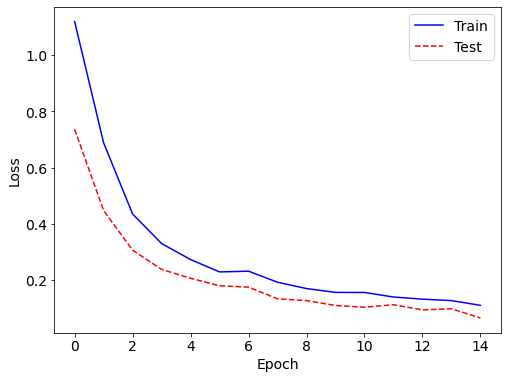

In [7]:
fs = 14
f, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(train_loss, color='blue', label='Train')
ax.plot(val_loss, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xlabel("Epoch", fontsize=fs)
ax.set_ylabel("Loss", fontsize=fs);

Test accuracy: 0.9757


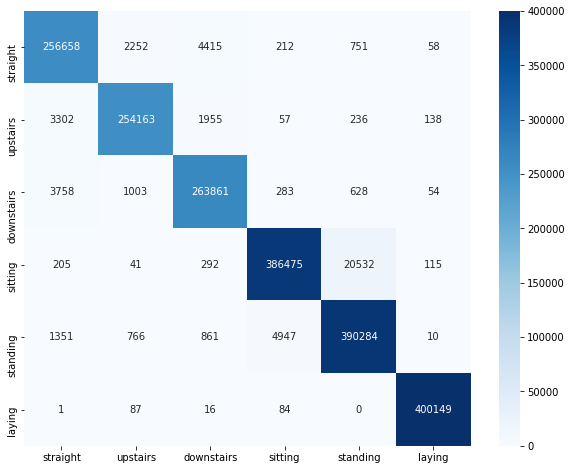

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

classes = ('straight', 'upstairs', 'downstairs', 'sitting', 'standing', 'laying')
y_true_np = torch.cat([y for _, y in test_dl]).cpu().numpy()
y_pred_np = torch.cat([model(x).argmax(2) for x, _ in test_dl]).cpu().numpy()

print(f'Test accuracy: {str((y_true_np == y_pred_np).sum() / y_true_np.size)[:6]}')

cm = confusion_matrix(y_true_np.reshape(-1), y_pred_np.reshape(-1))
f, ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d", xticklabels=classes, yticklabels=classes);